In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
DATA_DIR = "/content/drive/MyDrive/SDAI/intel/archive.zip"

In [ ]:
!unzip "/content/drive/MyDrive/SDAI/intel/archive.zip" -d "/content/drive/MyDrive/SDAI/intel/archive"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train/mountain/7647.jpg  

In [ ]:
# 2. Paths
train_dir = '/content/drive/MyDrive/SDAI/intel/archive/seg_train/seg_train'
test_dir = '/content/drive/MyDrive/SDAI/intel/archive/seg_test/seg_test'
model_save_path = 'cnn_classifier_weights.pth'

In [ ]:
# 3. Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# 4. Datasets & Dataloaders
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)





In [ ]:
# 5. Define CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleCNN(num_classes=len(train_data.classes)).to(device)

# 6. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 7. Training
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")




Epoch [1/10], Loss: 387.8505, Accuracy: 66.48%
Epoch [2/10], Loss: 251.5675, Accuracy: 79.20%
Epoch [3/10], Loss: 173.3713, Accuracy: 85.63%
Epoch [4/10], Loss: 111.9678, Accuracy: 90.91%
Epoch [5/10], Loss: 64.7595, Accuracy: 95.04%
Epoch [6/10], Loss: 36.6239, Accuracy: 97.32%
Epoch [7/10], Loss: 26.4559, Accuracy: 98.05%
Epoch [8/10], Loss: 20.8992, Accuracy: 98.53%
Epoch [9/10], Loss: 24.5238, Accuracy: 98.27%
Epoch [10/10], Loss: 17.0324, Accuracy: 98.86%


In [ ]:
# 8. Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Weights saved to: {model_save_path}")

Weights saved to: cnn_classifier_weights.pth


<Figure size 800x600 with 0 Axes>

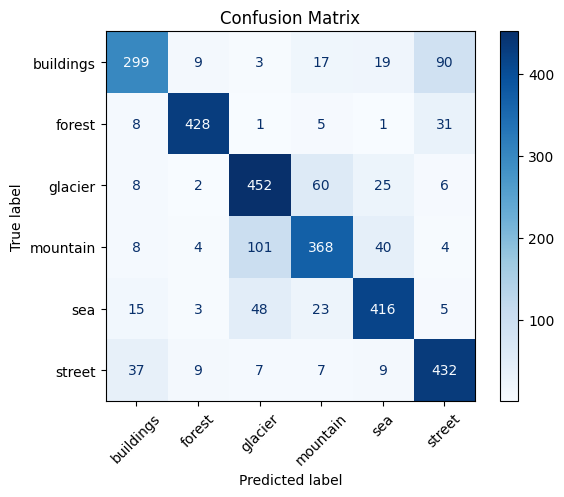

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

test_accuracy = accuracy_score(all_labels, all_preds) * 100
print(f"\n Final Test Accuracy: {test_accuracy:.2f}%")


 Final Test Accuracy: 79.83%
